In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string 
import re


In [ ]:
pip install wordcloud

In [3]:
df_raw = pd.read_excel("Online Retail.xlsx")

In [4]:
df = pd.read_excel("Online Retail.xlsx")

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.shape

(541909, 8)

## Preprocessing and EDA

### Data Quality Checks

In [10]:
# Missing values
print("Missing values per column: \n", df.isnull().sum())

Missing values per column: 
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [11]:
# Dropping Duplicates
df = df.drop_duplicates()
print("After dropping duplicates, data set shape:", df.shape)

After dropping duplicates, data set shape: (536641, 8)


In [12]:
# Negative 'Quantity' or 'UnitPrice'
negatives = df[(df.Quantity < 0) | (df.UnitPrice < 0)]
print("Negative transaction count: ", negatives.shape[0] )

Negative transaction count:  10589


In [13]:
# Fill missing description
df.Description = df.Description.fillna('Unknown')

In [14]:
df = df[df.Quantity > 0]

In [15]:
df.shape

(526054, 8)

In [16]:
# Convert Data Types
df.CustomerID = df.CustomerID.astype('Int64')
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df['Revenue'] = df.Quantity * df.UnitPrice

In [17]:
# Basic Statistics
print(df[['Quantity','UnitPrice', 'Revenue']]. describe())
print('Unique Customers:', df.CustomerID. nunique())
print('Unique Products:', df.StockCode. nunique())
print('Unique Invoices:', df.InvoiceNo. nunique())

            Quantity      UnitPrice        Revenue
count  526054.000000  526054.000000  526054.000000
mean       10.730874       3.871747      20.188016
std       157.591838      42.016560     272.250300
min         1.000000  -11062.060000  -11062.060000
25%         1.000000       1.250000       3.900000
50%         4.000000       2.080000       9.920000
75%        11.000000       4.130000      17.700000
max     80995.000000   13541.330000  168469.600000
Unique Customers: 4339
Unique Products: 3941
Unique Invoices: 20728


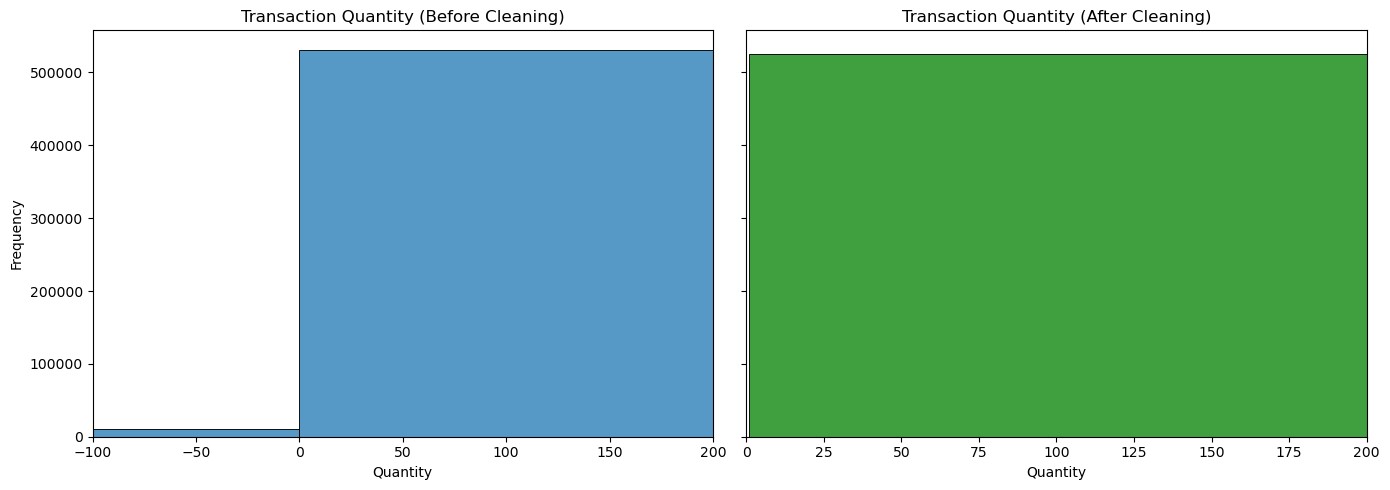

In [18]:
# Plotting Distribution of Quantity Before and After Cleaning
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# BEFORE cleaning
sns.histplot(df_raw["Quantity"], bins=50, ax=axes[0], kde=False)
axes[0].set_title("Transaction Quantity (Before Cleaning)")
axes[0].set_xlabel("Quantity")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 200)  # focus on main range (ignore extreme outliers)

# AFTER cleaning
sns.histplot(df["Quantity"], bins=50, ax=axes[1], kde=False, color="green")
axes[1].set_title("Transaction Quantity (After Cleaning)")
axes[1].set_xlabel("Quantity")
axes[1].set_xlim(0, 200)

plt.tight_layout()
plt.show()


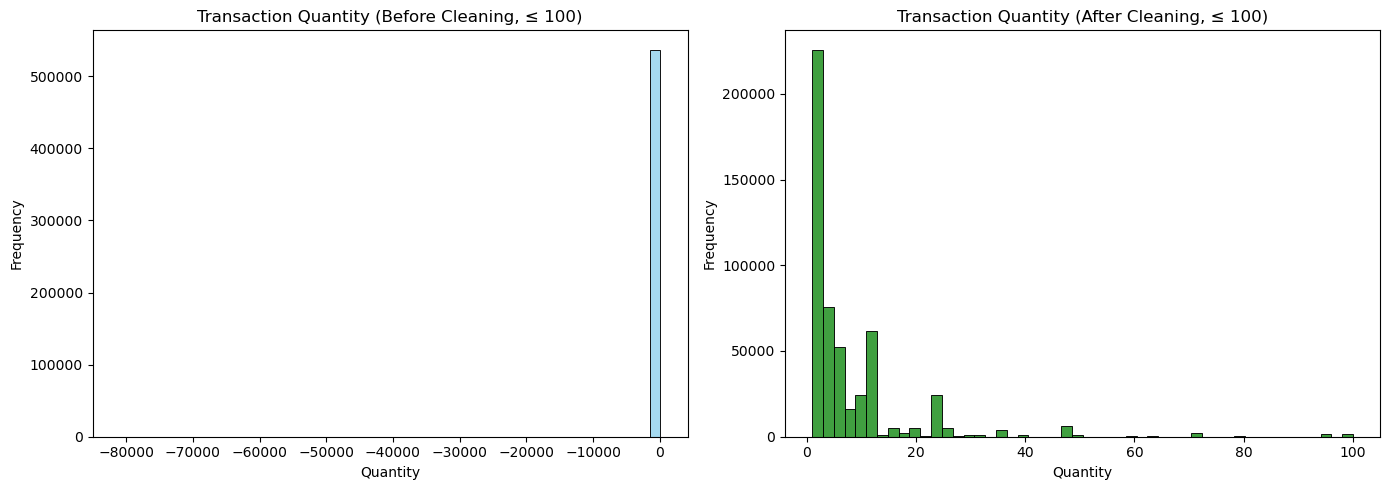

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before cleaning (truncate to <= 100)
sns.histplot(df_raw[df_raw["Quantity"] <= 100]["Quantity"], bins=50, ax=axes[0], kde=False, color="skyblue")
axes[0].set_title("Transaction Quantity (Before Cleaning, ≤ 100)")
axes[0].set_xlabel("Quantity")
axes[0].set_ylabel("Frequency")

# After cleaning (truncate to <= 100)
sns.histplot(df[df["Quantity"] <= 100]["Quantity"], bins=50, ax=axes[1], kde=False, color="green")
axes[1].set_title("Transaction Quantity (After Cleaning, ≤ 100)")
axes[1].set_xlabel("Quantity")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


### Customer Behaviour

In [21]:

customer_stats = df.groupby('CustomerID').agg({
    'InvoiceNo' : 'nunique',
    'Revenue' : 'sum',
    'Quantity' : 'sum'
}). rename(columns = {'InvoiceNo': 'NumTransactions','Revenue' : 'TotalRevenue', 'Quantity' : 'TotalQuantity'})

In [22]:
customer_stats

,NumTransactions,TotalRevenue,TotalQuantity
CustomerID,,,
12346,1,77183.60,74215
12347,7,4310.00,2458
12348,4,1797.24,2341
12349,1,1757.55,631
12350,1,334.40,197
...,...,...,...
18280,1,180.60,45
18281,1,80.82,54
18282,2,178.05,103


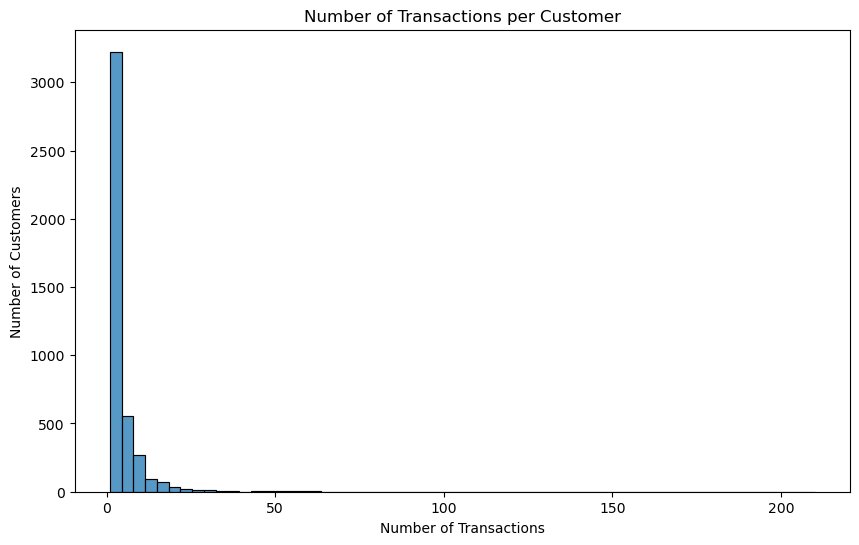

In [23]:
plt.figure(figsize=(10,6))
sns.histplot(customer_stats['NumTransactions'], bins = 60)
plt.title('Number of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [24]:
top_customers = customer_stats.sort_values('TotalRevenue', ascending = False).head(10)
print('Top 10 customers by revenue:\n', top_customers)

Top 10 customers by revenue:
             NumTransactions  TotalRevenue  TotalQuantity
CustomerID                                              
14646                    74     280206.02         197491
18102                    60     259657.30          64124
17450                    46     194390.79          69973
16446                     2     168472.50          80997
14911                   201     143711.17          80490
12415                    21     124914.53          77670
14156                    55     117210.08          57768
17511                    31      91062.38          64549
16029                    63      80850.84          40108
12346                     1      77183.60          74215


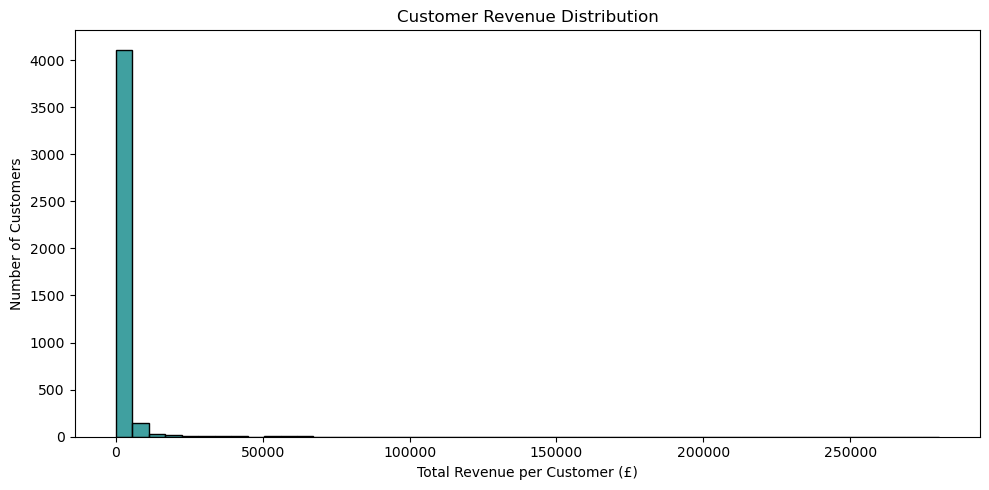

In [25]:
customer_revenue = df.groupby("CustomerID")["Revenue"].sum()

plt.figure(figsize=(10, 5))
sns.histplot(customer_revenue, bins=50, kde=False, color="teal")
plt.title("Customer Revenue Distribution")
plt.xlabel("Total Revenue per Customer (£)")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()

### Product Insights

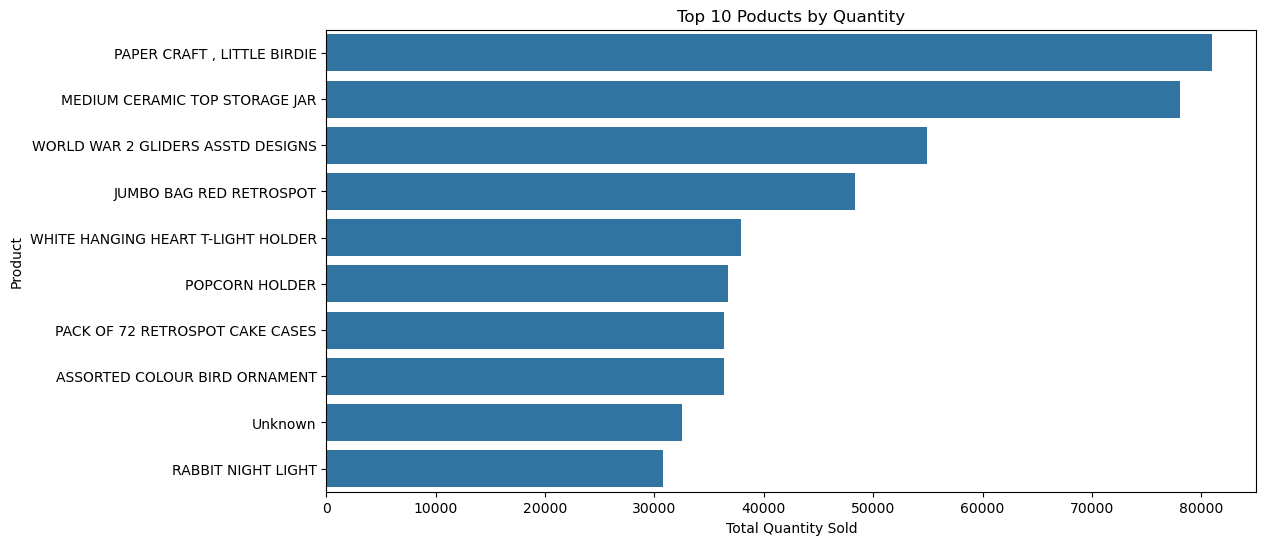

In [27]:
#Most Sold Products
top_products_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_products_qty.values, y=top_products_qty.index)
plt.title('Top 10 Poducts by Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.show()

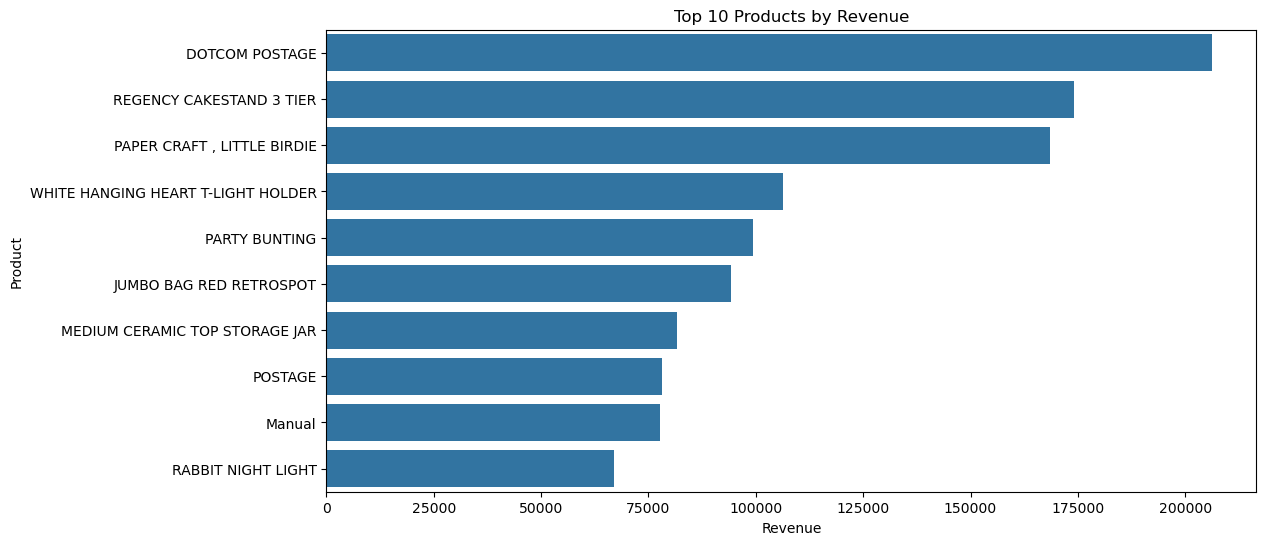

In [28]:
# Top revenue products
top_products_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending = False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_products_rev.values,y=top_products_rev.index)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.show()

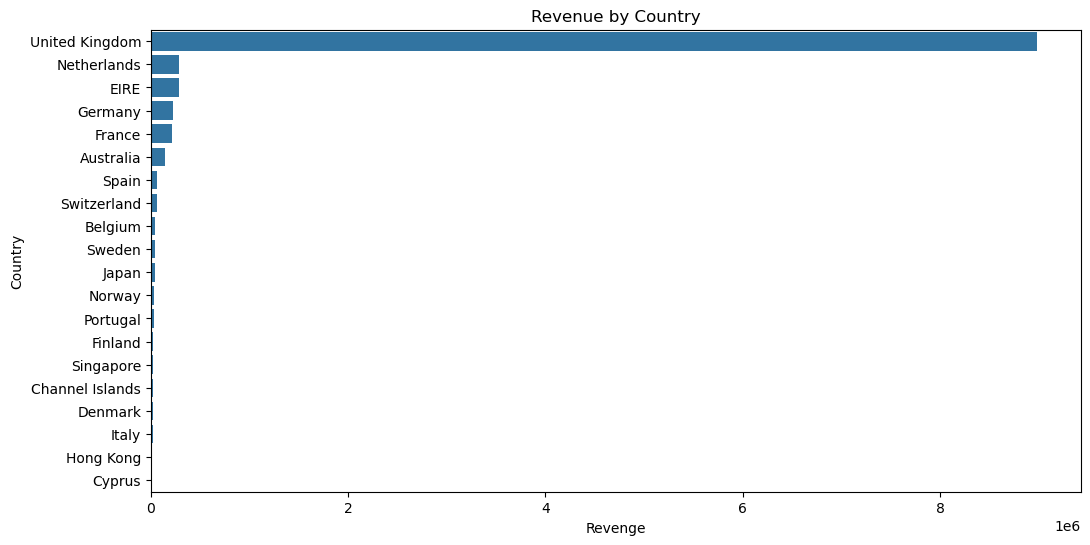

In [30]:
#Country-Level insights

country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index)
plt.title('Revenue by Country')
plt.xlabel('Revenge')
plt.ylabel('Country')
plt.show()

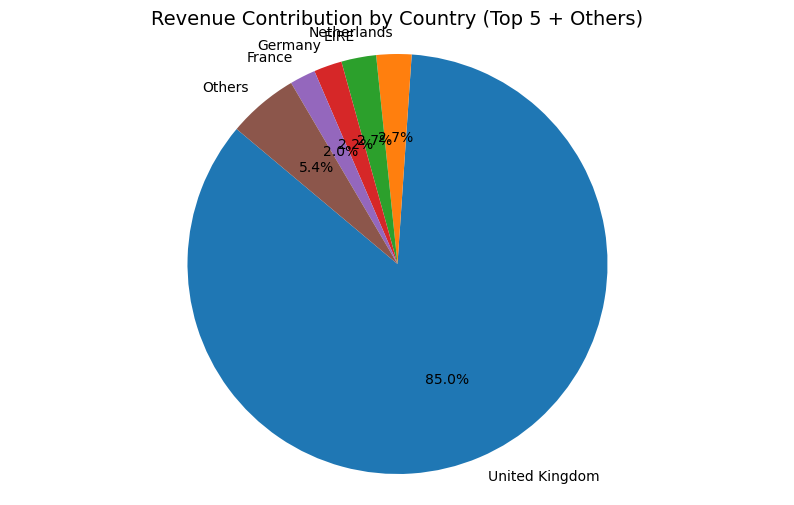

In [31]:
top_countries = country_revenue.head(5)
others = country_revenue.iloc[5:].sum()
top_countries['Others'] = others

plt.figure(figsize=(10,6))
plt.pie(
    top_countries,
    labels=top_countries.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Revenue Contribution by Country (Top 5 + Others)', fontsize=14)
plt.axis('equal')
plt.show()



In [32]:
# Text cleaning for Product Descriptions (Content-Based)

In [33]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
custom_stopwords = set(stopwords.words('english')).union(
    {"set", "pack", "assorted", "amazon"}
)

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removing punctuation
    words = [word for word in text.split() if word not in custom_stopwords]
    return " ".join(words)

df['CleanedDescription'] = df['Description'].fillna("").apply(clean_text)
# Keeping only rows with at least 3 words to ensure meaningful descriptions
df = df[df['CleanedDescription'].str.split().str.len() >= 3]

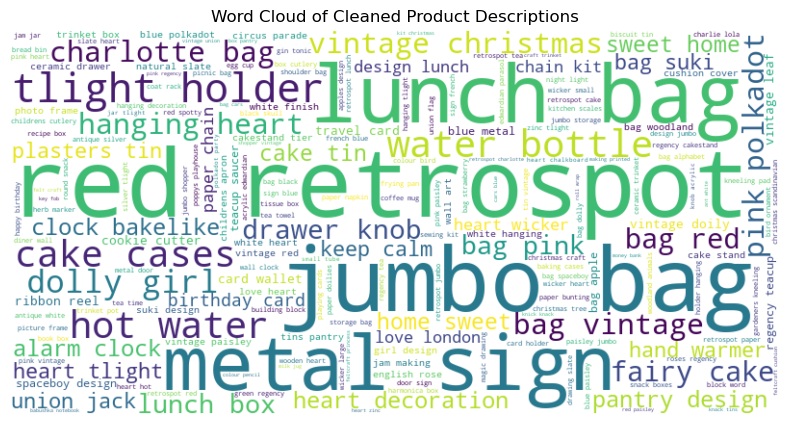

In [36]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    " ".join(df['CleanedDescription'])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Product Descriptions")
plt.show()


## Content-Based Filtering (CBF)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

df.Description = df.Description.fillna('').str.lower()

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df.CleanedDescription)

print('TF-IDF Matrix shape:', tfidf_matrix.shape)

nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

TF-IDF Matrix shape: (501371, 2048)


NearestNeighbors(algorithm='brute', metric='cosine')

In [41]:
# Unique product catalog
products = df[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)

# TF-IDF on cleaned product descriptions
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['Description'])

print("Products shape:", products.shape)
print("TF-IDF shape:", tfidf_matrix.shape)


Products shape: (4019, 2)
TF-IDF shape: (4019, 2054)


In [42]:
import re
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join(text.split())
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['CleanDescription'] = df['Description'].apply(clean_text)

df = df[df['CleanDescription'].str.len() > 3]

print(df[['Description', 'CleanDescription']].head(10))


                           Description                     CleanDescription
0   white hanging heart t-light holder    white hanging heart tlight holder
1                  white metal lantern                  white metal lantern
2       cream cupid hearts coat hanger       cream cupid hearts coat hanger
3  knitted union flag hot water bottle  knitted union flag hot water bottle
4       red woolly hottie white heart.        red woolly hottie white heart
5         set 7 babushka nesting boxes           set babushka nesting boxes
6    glass star frosted t-light holder     glass star frosted tlight holder
7               hand warmer union jack               hand warmer union jack
8            hand warmer red polka dot            hand warmer red polka dot
9        assorted colour bird ornament        assorted colour bird ornament


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# --- Rebuild unique product catalog ---
products = (
    df[['StockCode', 'CleanDescription']]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
)

print("Unique products after cleaning:", products.shape[0])

# --- TF-IDF on cleaned descriptions ---
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['CleanDescription'])

# --- Nearest Neighbors Model ---
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)


Unique products after cleaning: 3994


NearestNeighbors(algorithm='brute', metric='cosine')

In [45]:
def recommend_products(product_desc, top_n=5):
    # match against cleaned descriptions
    match = products[products['CleanDescription'].str.lower() == product_desc.lower()]
    if match.empty:
        return pd.DataFrame(columns=['StockCode', 'CleanDescription', 'Similarity'])
    
    idx = match.index[0]
    query_vec = tfidf_matrix[idx]
    
    distances, indices = nn.kneighbors(query_vec, n_neighbors=top_n+1)
    results = products.iloc[indices.flatten()].copy()
    results['Similarity'] = 1 - distances.flatten()
    
    return results.iloc[1:]  # drop the product itself


def recommend_for_customer(customer_id, top_n=5):
    purchased = df[df['CustomerID'] == customer_id]['StockCode'].unique()
    purchased_products = products[products['StockCode'].isin(purchased)]
    
    if purchased_products.empty:
        return f"No purchases found for Customer {customer_id}"
    
    all_recs = pd.DataFrame()
    for desc in purchased_products['CleanDescription']:
        recs = recommend_products(desc, top_n=3)
        all_recs = pd.concat([all_recs, recs])
    
    all_recs = all_recs[~all_recs['StockCode'].isin(purchased)]
    
    if all_recs.empty:
        return f"Customer {customer_id} has no new recommendations."
    
    final_recs = (
        all_recs.groupby(['StockCode', 'CleanDescription'])
        .agg({'Similarity': 'max'})
        .sort_values('Similarity', ascending=False)
        .head(top_n)
        .reset_index()
    )
    
    return final_recs


In [46]:
print("CBF Recommendations for 12347:")
print(recommend_for_customer(12347, top_n=5))


CBF Recommendations for 12347:
  StockCode                 CleanDescription  Similarity
0    84997b  childrens cutlery retrospot red    1.000000
1    84559b               sheet cat stickers    1.000000
2    84559a               sheet dog stickers    1.000000
3     82580              bathroom metal sign    1.000000
4     21264      white goose feather tree cm    0.914472


In [47]:
print("CBF Recommendations for 12748:")
print(recommend_for_customer(12748, top_n=5))


CBF Recommendations for 12748:
  StockCode                CleanDescription  Similarity
0    84993a          green petit four cases         1.0
1    46000R        polyester filler pad xcm         1.0
2    72807c  set vanilla scented candle box         1.0
3    85035c     rose wick morris box candle         1.0
4     72134           columbian cube candle         1.0


In [48]:
# Show products already purchased by a customer
def get_customer_purchases(customer_id):
    customer_data = df[df['CustomerID'] == customer_id]
    purchased_products = (
        customer_data[['StockCode', 'Description']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    return purchased_products

# Example: View purchases for Customer 12347
customer_12347_purchases = get_customer_purchases(12347)
print(f"Products purchased by Customer 12347: ({len(customer_12347_purchases)} unique items)")
display(customer_12347_purchases)


Products purchased by Customer 12347: (102 unique items)


,StockCode,Description
0,85116,black candelabra t-light holder
1,22375,airline bag vintage jet set brown
2,71477,colour glass. star t-light holder
3,22492,mini paint set vintage
4,22771,clear drawer knob acrylic edwardian
...,...,...
97,23420,pantry hook tea strainer
98,22131,food container set 3 love heart
99,23497,classic chrome bicycle bell
100,23552,bicycle puncture repair kit


In [51]:
custom_stopwords = stop_words.union({
    "amazon", "set", "assorted", "pack", "of", "box", "pcs", "piece"
})

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = " ".join(text.split())  # normalize whitespace
    text = " ".join([word for word in text.split() if word not in custom_stopwords])
    return text

df['CleanDescription'] = df['Description'].apply(clean_text)

# remove very short (1-2 word) descriptions
df = df[df['CleanDescription'].str.split().str.len() > 2]


In [52]:
products = (
    df[['StockCode', 'CleanDescription']]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
)

print("Unique products after cleaning:", products.shape[0])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# TF-IDF on cleaned descriptions
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['CleanDescription'])

# Nearest Neighbors model
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

print("TF-IDF Matrix shape:", tfidf_matrix.shape)


Unique products after cleaning: 3964
TF-IDF Matrix shape: (3964, 2036)


In [53]:
def recommend_products(product_desc, top_n=5):
    match = products[products['CleanDescription'].str.lower() == product_desc.lower()]
    if match.empty:
        return pd.DataFrame(columns=['StockCode', 'CleanDescription', 'Similarity'])
    
    idx = match.index[0]
    query_vec = tfidf_matrix[idx]
    
    distances, indices = nn.kneighbors(query_vec, n_neighbors=top_n+1)
    results = products.iloc[indices.flatten()].copy()
    results['Similarity'] = 1 - distances.flatten()
    
    return results.iloc[1:]  # drop the item itself


def recommend_for_customer(customer_id, top_n=5):
    purchased = df[df['CustomerID'] == customer_id]['StockCode'].unique()
    purchased_products = products[products['StockCode'].isin(purchased)]
    
    if purchased_products.empty:
        return f"No purchases found for Customer {customer_id}"
    
    all_recs = pd.DataFrame()
    for desc in purchased_products['CleanDescription']:
        recs = recommend_products(desc, top_n=3)
        all_recs = pd.concat([all_recs, recs])
    
    all_recs = all_recs[~all_recs['StockCode'].isin(purchased)]
    
    if all_recs.empty:
        return f"Customer {customer_id} has no new recommendations."
    
    final_recs = (
        all_recs.groupby(['StockCode', 'CleanDescription'])
        .agg({'Similarity': 'max'})
        .sort_values('Similarity', ascending=False)
        .head(top_n)
        .reset_index()
    )
    
    return final_recs

In [54]:
print(recommend_for_customer(12347, top_n=10))

  StockCode                 CleanDescription  Similarity
0    84997b  childrens cutlery retrospot red    1.000000
1    47559b              tea time oven glove    1.000000
2    84997b            red retrospot cutlery    1.000000
3    84997c  childrens cutlery polkadot blue    1.000000
4    84997d            pink polkadot cutlery    1.000000
5     21264      white goose feather tree cm    0.914588
6     21263      green goose feather tree cm    0.908989
7     22135       mini ladle love heart pink    0.900664
8     20781         gold ear muff headphones    0.877794
9     22135            ladle love heart pink    0.877726


## Collaborative Filtering (CF)

### User-Item Matrix( for Collaborative filtering)

In [57]:
df_reco = df.dropna(subset=['CustomerID'])
df_reco['CustomerID'] = df_reco['CustomerID'].astype(int)

user_item_matrix = df_reco.pivot_table(index = 'CustomerID',
                                      columns = 'CleanDescription',
                                      values = 'Quantity',
                                      aggfunc ='sum',
                                      fill_value =0)
print('User-Item Matrix Shape:', user_item_matrix.shape)


C:\Users\HP\AppData\Local\Temp\ipykernel_27528\2305729647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reco['CustomerID'] = df_reco['CustomerID'].astype(int)


User-Item Matrix Shape: (4325, 3608)


In [58]:
#Sparsity
sparsity = 1- (np.count_nonzero(user_item_matrix) / user_item_matrix.size )
print('User-Item Matrix Sparsity:', round(sparsity*100,2), '%')

User-Item Matrix Sparsity: 98.38 %


### User-Based CF

In [61]:
user_item_matrix = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

In [62]:
user_item_binary = (user_item_matrix > 0).astype(int)

In [63]:
print("User-Item Matrix Shape:", user_item_binary.shape)

User-Item Matrix Shape: (4325, 3504)


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_item_matrix.index, 
                                  columns=user_item_matrix.index)

print("User-User Similarity Matrix shape:", user_similarity_df.shape)

User-User Similarity Matrix shape: (4325, 4325)


In [65]:
def recommend_cf(customer_id, top_n_users=5, top_n_items=5):
    if customer_id not in user_item_matrix.index:
        return f"Customer {customer_id} not found."

    sim_scores = user_similarity_df.loc[customer_id].sort_values(ascending=False)

    top_users = sim_scores.iloc[1:top_n_users+1].index

    similar_users_items = user_item_matrix.loc[top_users].sum(axis=0)

    items_already_purchased = user_item_matrix.loc[customer_id]
    recommended_items = similar_users_items[items_already_purchased == 0]

    top_recommendations = recommended_items.sort_values(ascending=False).head(top_n_items)

    top_recommendations = (
        top_recommendations.reset_index()
        .merge(df[['StockCode', 'Description']].drop_duplicates(), 
               on='StockCode', how='left')
    )
    
    return top_recommendations

# Example
print("User-based Recommendations for 12347:")
print(recommend_cf(12347, top_n_users=5, top_n_items=5))

User-based Recommendations for 12347:
  StockCode   0                         Description
0     22693  72  grow a flytrap or sunflower in tin
1     22418  72              10 colour spaceboy pen
2     23077  60                 doughnut lip gloss 
3     22065  48      christmas pudding trinket pot 
4     22469  48               heart of wicker small


In [66]:
def recommend_cf(customer_id, top_n_users=5, top_n_items=5):
    if customer_id not in user_item_matrix.index:
        return f"Customer {customer_id} not found."

    # Finding similar users
    sim_scores = user_similarity_df.loc[customer_id].sort_values(ascending=False)
    top_users = sim_scores.iloc[1:top_n_users+1].index

    # Aggregating items from top similar users
    similar_users_items = user_item_matrix.loc[top_users].sum(axis=0)

    # Removing items already purchased
    items_already_purchased = user_item_matrix.loc[customer_id]
    recommended_items = similar_users_items[items_already_purchased == 0]

    # Picking top-N
    top_recommendations = recommended_items.sort_values(ascending=False).head(top_n_items)

    # Merging with product descriptions
    top_recommendations = (
        top_recommendations.reset_index()
        .merge(df[['StockCode', 'Description']].drop_duplicates(), 
               on='StockCode', how='left')
    )

    # Products already purchased
    purchased_products = (
        df[df['CustomerID'] == customer_id][['StockCode', 'Description']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return purchased_products, top_recommendations


# Example usage
purchased, recommendations = recommend_cf(12347, top_n_users=5, top_n_items=5)

print("Products already purchased by Customer 12347:")
print(purchased.head(15))  # show first 15 purchases

print("\n Recommended products for Customer 12347:")
print(recommendations)


Products already purchased by Customer 12347:
   StockCode                          Description
0      85116      black candelabra t-light holder
1      22375    airline bag vintage jet set brown
2      71477    colour glass. star t-light holder
3      22492              mini paint set vintage 
4      22771  clear drawer knob acrylic edwardian
5      22772   pink drawer knob acrylic edwardian
6      22773  green drawer knob acrylic edwardian
7      22774    red drawer knob acrylic edwardian
8      22775  purple drawerknob acrylic edwardian
9      22805   blue drawer knob acrylic edwardian
10     22725       alarm clock bakelike chocolate
11     22726           alarm clock bakelike green
12     22727            alarm clock bakelike red 
13     22728            alarm clock bakelike pink
14     22729          alarm clock bakelike orange

 Recommended products for Customer 12347:
  StockCode   0                         Description
0     22693  72  grow a flytrap or sunflower in tin
1     2

In [67]:
# Example usage
purchased, recommendations = recommend_cf(12748, top_n_users=5, top_n_items=5)

print("Products already purchased by Customer 12748:")
print(purchased.head(15))  

print("\n Recommended products for Customer 12748:")
print(recommendations)

Products already purchased by Customer 12748:
   StockCode                          Description
0      22854          cream sweetheart egg holder
1      22187     green christmas tree card holder
2      20894  hanging bauble t-light holder large
3     85018D      yuletide images s/6 paper boxes
4      21413            periwinkle t-light holder
5     79149B              silicon star bulb  blue
6      21682     large medina stamped metal bowl 
7     78034B          blue netting storage hanger
8      22894        tablecloth red apples design 
9     79151B               silicon cube 25w, blue
10     21664   ridged glass storage jar cream lid
11    71406C                black orange squeezer
12     21090           set/6 collage paper plates
13    85049A        traditional christmas ribbons
14     21209            multicolour honeycomb fan

 Recommended products for Customer 12748:
  StockCode   0                         Description
0     84947  72   antique silver tea glass engraved
1     1

### Item-Based CF

In [69]:
#Transpose user-item matrix to get item-user matrix
item_user_matrix = user_item_matrix.T
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=item_user_matrix.index,
    columns=item_user_matrix.index
)

print("Item-Item Similarity Matrix Shape:", item_similarity_df.shape)

Item-Item Similarity Matrix Shape: (3504, 3504)


In [70]:
def recommend_cf_itembased(customer_id, top_n_items=5):
    if customer_id not in user_item_matrix.index:
        return f"Customer {customer_id} not found."

    # Getting items purchased by the customer
    customer_items = user_item_matrix.loc[customer_id]
    purchased_items = customer_items[customer_items > 0].index.tolist()

    if not purchased_items:
        return f"Customer {customer_id} has no purchases."

    # Finding similar items using item similarity
    scores = pd.Series(0, index=user_item_matrix.columns)

    for item in purchased_items:
        if item in item_similarity_df.index:
            scores = scores.add(item_similarity_df.loc[item], fill_value=0)

    # Removing items already purchased
    scores = scores.drop(purchased_items, errors="ignore")

    # Picking top-N recommended items
    top_recommendations = scores.sort_values(ascending=False).head(top_n_items)

    # Merging with product descriptions
    top_recommendations = (
        top_recommendations.reset_index()
        .merge(df[['StockCode', 'Description']].drop_duplicates(),
               on='StockCode', how='left')
        .rename(columns={0: "Score"})
    )

    # Products already purchased
    purchased_products = (
        df[df['CustomerID'] == customer_id][['StockCode', 'Description']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return purchased_products, top_recommendations


# Example usage
purchased_i, recommendations_i = recommend_cf_itembased(12347, top_n_items=5)

print("Products already purchased by Customer 12347:")
print(purchased_i.head(15))  # first 15 purchases

print("\n Item-based Recommended products for Customer 12347:")
print(recommendations_i)


Products already purchased by Customer 12347:
   StockCode                          Description
0      85116      black candelabra t-light holder
1      22375    airline bag vintage jet set brown
2      71477    colour glass. star t-light holder
3      22492              mini paint set vintage 
4      22771  clear drawer knob acrylic edwardian
5      22772   pink drawer knob acrylic edwardian
6      22773  green drawer knob acrylic edwardian
7      22774    red drawer knob acrylic edwardian
8      22775  purple drawerknob acrylic edwardian
9      22805   blue drawer knob acrylic edwardian
10     22725       alarm clock bakelike chocolate
11     22726           alarm clock bakelike green
12     22727            alarm clock bakelike red 
13     22728            alarm clock bakelike pink
14     22729          alarm clock bakelike orange

 Item-based Recommended products for Customer 12347:
  StockCode      Score                       Description
0     23110  19.788486           parisienne

In [71]:
# Example usage
purchased_i, recommendations_i = recommend_cf_itembased(12748, top_n_items=5)

print("Products already purchased by Customer 12748:")
print(purchased_i.head(15)) 

print("\n Item-based Recommended products for Customer 12748:")
print(recommendations_i)

Products already purchased by Customer 12748:
   StockCode                          Description
0      22854          cream sweetheart egg holder
1      22187     green christmas tree card holder
2      20894  hanging bauble t-light holder large
3     85018D      yuletide images s/6 paper boxes
4      21413            periwinkle t-light holder
5     79149B              silicon star bulb  blue
6      21682     large medina stamped metal bowl 
7     78034B          blue netting storage hanger
8      22894        tablecloth red apples design 
9     79151B               silicon cube 25w, blue
10     21664   ridged glass storage jar cream lid
11    71406C                black orange squeezer
12     21090           set/6 collage paper plates
13    85049A        traditional christmas ribbons
14     21209            multicolour honeycomb fan

 Item-based Recommended products for Customer 12748:
  StockCode       Score                         Description
0     23110  251.009878             pari

## Hybrid Filtering

### Weighted Hybrid (Score Blending)

In [74]:

from sklearn.preprocessing import MinMaxScaler

def hybrid_recommend(customer_id, top_n=5, alpha=0.5):
    """
    Hybrid recommendation combining CBF + CF
    alpha = weight for CBF (0.5 means 50% CBF + 50% CF)
    """
    
    purchased = df[df['CustomerID'] == customer_id]['StockCode'].unique()
    purchased_products = products[products['StockCode'].isin(purchased)]
    
    cbf_recs = pd.DataFrame()
    for desc in purchased_products['CleanDescription']:
        recs = recommend_products(desc, top_n=top_n)
        cbf_recs = pd.concat([cbf_recs, recs])
    
    cbf_recs = (
        cbf_recs.groupby(['StockCode', 'CleanDescription'])
        .agg({'Similarity':'max'})
        .reset_index()
    )
    
    
    _, cf_recs = recommend_cf_itembased(customer_id, top_n_items=top_n*2)
    cf_recs = cf_recs.rename(columns={0:'Score'})
    
    
    scaler = MinMaxScaler()
    if not cbf_recs.empty:
        cbf_recs['CBF_Score'] = scaler.fit_transform(cbf_recs[['Similarity']])
    if not cf_recs.empty:
        cf_recs['CF_Score'] = scaler.fit_transform(cf_recs[['Score']])
    
    
    hybrid = pd.merge(cbf_recs, cf_recs, on="StockCode", how="outer")
    hybrid = hybrid.fillna(0)
    
    
    hybrid['Hybrid_Score'] = alpha * hybrid['CBF_Score'] + (1-alpha) * hybrid['CF_Score']
    
    final = hybrid.sort_values('Hybrid_Score', ascending=False).head(top_n)
    return final[['StockCode', 'CleanDescription', 'Hybrid_Score']]
    

# Example
print("Hybrid recommendations for Customer 12347:")
print(hybrid_recommend(12347, top_n=5, alpha=0.6))


Hybrid recommendations for Customer 12347:
    StockCode                 CleanDescription  Hybrid_Score
319    47559b              tea time oven glove           0.6
330    84558A        dog picture playing cards           0.6
366    84997c            blue polkadot cutlery           0.6
357    84997B  childrens cutlery retrospot red           0.6
365    84997b            red retrospot cutlery           0.6


In [75]:
print(" Weighted Hybrid recommendations for Customer 12748:")
print(hybrid_recommend(12748, top_n=5, alpha=0.6))


 Weighted Hybrid recommendations for Customer 12748:
     StockCode                 CleanDescription  Hybrid_Score
1195     22716               card circus parade       0.77462
2471    72802C    vanilla scent candle jewelled       0.60000
1454     23040    paper lantern point snow star       0.60000
2674    84997c            blue polkadot cutlery       0.60000
2675    84997c  childrens cutlery polkadot blue       0.60000


### Switching Hybrid

In [76]:
def recommend_hybrid_switching(customer_id, min_purchases=5, top_n=5):
    """
    Switching Hybrid: 
    - If customer has less than 'min_purchases' → use Content-Based Filtering
    - Else → use Collaborative Filtering
    """
    # products purchased
    purchased = df[df['CustomerID'] == customer_id]['StockCode'].unique()
    
    if len(purchased) == 0:
        return f"No purchases for Customer {customer_id}."
    
    if len(purchased) < min_purchases:
        # use Content-Based
        print(f"Using Content-Based for Customer {customer_id} (cold start)")
        recs = pd.DataFrame()
        for desc in products[products['StockCode'].isin(purchased)]['CleanDescription']:
            recs = pd.concat([recs, recommend_products(desc, top_n=3)])
        recs = recs[~recs['StockCode'].isin(purchased)]
        return (
            recs.groupby(['StockCode', 'CleanDescription'])
            .agg({'Similarity': 'max'})
            .sort_values('Similarity', ascending=False)
            .head(top_n)
            .reset_index()
        )
    else:
        # use Collaborative Filtering
        print(f"Using Collaborative Filtering for Customer {customer_id}")
        purchased_i, recs = recommend_cf_itembased(customer_id, top_n_items=top_n)
        return recs


# Example usage
print("Hybrid-Switching Recommendations for 12347:")
print(recommend_hybrid_switching(12347, min_purchases=5, top_n=5))


Hybrid-Switching Recommendations for 12347:
Using Collaborative Filtering for Customer 12347
  StockCode      Score                       Description
0     23110  19.788486           parisienne key cabinet 
1     22907  19.704096  pack of 20 napkins pantry design
2     22505  19.063100         memo board cottage design
3     22557  18.911005  plasters in tin vintage paisley 
4     22966  18.882614     gingerbread man cookie cutter


In [77]:
print("Hybrid-Switching Recommendations for 12748:")
print(recommend_hybrid_switching(12748, min_purchases=5, top_n=5))

Hybrid-Switching Recommendations for 12748:
Using Collaborative Filtering for Customer 12748
  StockCode       Score                         Description
0     23110  251.009878             parisienne key cabinet 
1     22716  245.205609                  card circus parade
2     22378  237.865140                wall tidy retrospot 
3     23291  232.987070            dolly girl childrens cup
4     22329  230.370160  round container set of 5 retrospot


In [78]:
customer_activity = df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending=False)

print(customer_activity.head(10))

CustomerID
12748    204
14911    197
17841    124
13089     97
15311     91
14606     90
12971     85
14646     73
16029     61
13408     60
Name: InvoiceNo, dtype: int64


In [79]:
# purchased items
purchased_items = df[df["CustomerID"] == 12748][["StockCode", "Description"]].drop_duplicates()
print("Purchased products by 12748:")
print(purchased_items.head(15)) 

Purchased products by 12748:
     StockCode                          Description
1016     22854          cream sweetheart egg holder
3692     22187     green christmas tree card holder
8448     20894  hanging bauble t-light holder large
8449    85018D      yuletide images s/6 paper boxes
8450     21413            periwinkle t-light holder
8451    79149B              silicon star bulb  blue
8452     21682     large medina stamped metal bowl 
8453    78034B          blue netting storage hanger
8454     22894        tablecloth red apples design 
8455    79151B               silicon cube 25w, blue
8458     21664   ridged glass storage jar cream lid
8459    71406C                black orange squeezer
8460     21090           set/6 collage paper plates
8461    85049A        traditional christmas ribbons
8462     21209            multicolour honeycomb fan


# Evaluation

In [80]:
#Filtering valid customers (with at least 5 purchases to allow split)
valid_customers = df.groupby("CustomerID").filter(lambda x: len(x) >= 5)

In [81]:
train_list, test_list = [], []
for cust, group in valid_customers.groupby("CustomerID"):
    group = group.sample(frac=1, random_state=42)  # shuffle
    cutoff = int(len(group) * 0.8)
    train_list.append(group.iloc[:cutoff])
    test_list.append(group.iloc[cutoff:])

train_data = pd.concat(train_list).reset_index(drop=True)
test_data = pd.concat(test_list).reset_index(drop=True)

print("Train size:", train_data.shape, " Test size:", test_data.shape)

Train size: (293891, 11)  Test size: (75477, 11)


In [82]:
def evaluate_recommender(recommend_func, user_ids, k=5):
    precision_list, recall_list, f1_list = [], [], []
    
    for user in user_ids:
        actual_items = set(test_data[test_data["CustomerID"] == user]["StockCode"])
        if len(actual_items) == 0:
            continue
        
        try:
            recs = recommend_func(user, top_n=k)
            if isinstance(recs, pd.DataFrame) and "StockCode" in recs.columns:
                recommended_items = set(recs["StockCode"].tolist())
            else:
                recommended_items = set()
        except:
            recommended_items = set()
        
        # Calculating metrics
        true_positives = len(recommended_items & actual_items)
        precision = true_positives / len(recommended_items) if recommended_items else 0
        recall = true_positives / len(actual_items) if actual_items else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision+recall) > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    return {
        f"Precision@{k}": np.mean(precision_list),
        f"Recall@{k}": np.mean(recall_list),
        f"F1@{k}": np.mean(f1_list)
    }


In [88]:
# Example for CBF recommender wrapper
def recommend_cbf_eval(customer_id, top_n=5):
    return recommend_for_customer(customer_id, top_n=top_n)

# Same wrappers for CF + Hybrid
def recommend_cf_user_eval(customer_id, top_n=5):
    return recommend_cf(customer_id, top_n_users=5, top_n_items=top_n)

def recommend_cf_item_eval(customer_id, top_n=5):
    return recommend_cf_item(customer_id, top_n=top_n)

def recommend_hybrid_weighted_eval(customer_id, top_n=5):
    return recommend_hybrid_recommend(customer_id, top_n=top_n)

def recommend_hybrid_switching_eval(customer_id, top_n=5):
    return recommend_hybrid_switching(customer_id, top_n=top_n)


In [ ]:
user_ids = test_data["CustomerID"].unique()

results_cbf = evaluate_recommender(recommend_cbf_eval, user_ids, k=5)
results_cf_user = evaluate_recommender(recommend_cf_user_eval, user_ids, k=5)
results_cf_item = evaluate_recommender(recommend_cf_item_eval, user_ids, k=5)
results_hybrid_weighted = evaluate_recommender(recommend_hybrid_weighted_eval, user_ids, k=5)
results_hybrid_switching = evaluate_recommender(recommend_hybrid_switching_eval, user_ids, k=5)

print("CBF:", results_cbf)
print("User-CF:", results_cf_user)
print("Item-CF:", results_cf_item)
print("Hybrid-Weighted:", results_hybrid_weighted)
print("Hybrid-Switching:", results_hybrid_switching)


In [149]:
user_ids = test_data["CustomerID"].unique()

In [85]:
user_ids = test_data["CustomerID"].unique()
# Taking a small random sample of users for quick testing
sample_user_ids = np.random.choice(user_ids, size=20, replace=False)  # pick 20 users

# Running evaluation only on this subset
results_cbf_sample = evaluate_recommender(recommend_cbf_eval, sample_user_ids, k=5)
results_cf_user_sample = evaluate_recommender(recommend_cf_user_eval, sample_user_ids, k=5)
results_cf_item_sample = evaluate_recommender(recommend_cf_item_eval, sample_user_ids, k=5)
results_hybrid_weighted_sample = evaluate_recommender(recommend_hybrid_weighted_eval, sample_user_ids, k=5)
results_hybrid_switching_sample = evaluate_recommender(recommend_hybrid_switching_eval, sample_user_ids, k=5)

print("SAMPLE RUN RESULTS")
print("CBF:", results_cbf_sample)
print("User-CF:", results_cf_user_sample)
print("Item-CF:", results_cf_item_sample)
print("Hybrid-Weighted:", results_hybrid_weighted_sample)
print("Hybrid-Switching:", results_hybrid_switching_sample)


Using Collaborative Filtering for Customer 13248
Using Collaborative Filtering for Customer 16717
Using Collaborative Filtering for Customer 13357
Using Collaborative Filtering for Customer 15746
Using Collaborative Filtering for Customer 15266
Using Collaborative Filtering for Customer 16404
Using Collaborative Filtering for Customer 15158
Using Collaborative Filtering for Customer 13894
Using Collaborative Filtering for Customer 12890
Using Collaborative Filtering for Customer 14494
Using Collaborative Filtering for Customer 13026
Using Collaborative Filtering for Customer 15705
Using Collaborative Filtering for Customer 16525
Using Collaborative Filtering for Customer 17217
Using Collaborative Filtering for Customer 15224
Using Collaborative Filtering for Customer 16177
Using Collaborative Filtering for Customer 16091
Using Collaborative Filtering for Customer 14475
Using Collaborative Filtering for Customer 15463
Using Collaborative Filtering for Customer 16553
SAMPLE RUN RESULTS
C

In [151]:
print("Train size:", train_data.shape, " Test size:", test_data.shape)
print("Number of unique customers in train:", train_data['CustomerID'].nunique())
print("Number of unique customers in test:", test_data['CustomerID'].nunique())

# Checking one random user to ensure they have items in both train and test
random_user = np.random.choice(user_ids)
print("Train items for random user:", train_data[train_data["CustomerID"] == random_user]["StockCode"].tolist())
print("Test items for random user:", test_data[test_data["CustomerID"] == random_user]["StockCode"].tolist())


Train size: (293891, 11)  Test size: (75477, 11)
Number of unique customers in train: 4086
Number of unique customers in test: 4086
Train items for random user: ['84536B', 21485, 23236, 21754, '46000P', 22548, 22451, 21067, 22567, 22111, 22834, 23415, '85123A', 22900, 20983, 21721, 21040, 20750, 22111, 21754, 23398, 21993, 22625, 22961, 21754, 22975, 22834, 21726, '90003D', 22900, '84536A', 22558, '85049A', 23075, 22713, '84535B', 22989, 22092, 22984, 21232, 21890, 22059, 22972, '85232D', 22500, '85184C', 21925, 21429, '85049D', 21430, 82482, 22755, 22435, '51020A', 20982, 20754, 22720, '85049C', 23366, '84709B', 23399, '82494L', 22497, 22834, '85231G', 22973, 22080, '15056N', 21591, 23003, 84836, 82483, 23396, '85123A', 22352, 22082, 22900, 16237, 22804, '46000S', 21733, 22078, 22297, 22558, 23035, '82494L', 23438, '82494L', 22554, 22652, '84032B', 22558, 22834, 21754, 22558, 84658, 20981, 22450, 82484, 82483, '85232D', 22900, 82483, 22914, '85049E', 22558, 21754, 21871, 82482, 22557,

In [153]:
import re


def clean_text_function(text):
    if isinstance(text, str):
        text = text.lower()  # lowercase
        text = re.sub(r'[^a-z0-9\s]', '', text)  
        text = re.sub(r'\s+', ' ', text).strip() 
        return text
    return ""


In [155]:

products_train = train_data[['StockCode', 'Description']].drop_duplicates()

products_train['CleanDescription'] = products_train['Description'].apply(clean_text_function)


In [157]:
test_user = random_user
print("TESTING FOR USER:", test_user)

print("Actual Test Items:", set(test_data[test_data["CustomerID"] == test_user]["StockCode"]))

cbf_recs = recommend_cbf_eval(test_user, top_n=5)
print("CBF Recs:", cbf_recs)

cf_user_recs = recommend_cf_user_eval(test_user, top_n=5)
print("User-CF Recs:", cf_user_recs)

cf_item_recs = recommend_cf_item_eval(test_user, top_n=5)
print("Item-CF Recs:", cf_item_recs)


TESTING FOR USER: 17894
Actual Test Items: {23307, '46000M', 22553, 22556, 22567, 21544, 21034, 82482, 22970, 22971, '90209C', '85049H', 22078, 22720, 22082, '85036A', 22606, 84946, '85123A', 21340, 22494, 22367, 22111, 23393, 22754, '85049D', 21485, 23405, 22899, 22900, 21877, '84535B'}
CBF Recs:   StockCode                   CleanDescription  Similarity
0     20964           polyester filler pad xcm         1.0
1    15056n          edwardian parasol natural         1.0
2    85184c          valentine decoupage heart         1.0
3    85123a  white hanging heart tlight holder         1.0
4    85049c             romantic pinks ribbons         1.0
User-CF Recs: (    StockCode                         Description
0      82494L         wooden frame antique white 
1       82482   wooden picture frame white finish
2       22435      set of 9 heart shaped balloons
3       82483  wood 2 drawer cabinet white finish
4       22900     set 2 tea towels i love london 
..        ...                   

NameError: name 'recommend_cf_item' is not defined

In [159]:
def recommend_cf_item(customer_id, top_n=5):
    if customer_id not in user_item_matrix.index:
        return pd.DataFrame(columns=['StockCode', 'Description'])
    
    
    purchased_items = user_item_matrix.loc[customer_id]
    purchased_items = purchased_items[purchased_items > 0].index

    if len(purchased_items) == 0:
        return pd.DataFrame(columns=['StockCode', 'Description'])
    
    
    scores = pd.Series(0, index=user_item_matrix.columns, dtype=float)
    for item in purchased_items:
        scores += item_similarity_df.loc[item]  
    
    
    scores = scores.drop(purchased_items, errors="ignore")
    
    
    top_recommendations = scores.sort_values(ascending=False).head(top_n)
    
    
    top_recommendations = (
        top_recommendations.reset_index()
        .rename(columns={0: 'Score', 'StockCode': 'StockCode'})
        .merge(df[['StockCode', 'Description']].drop_duplicates(),
               on='StockCode', how='left')
    )
    return top_recommendations

# Example usage
print("Item-based Recommendations for 16554:")
print(recommend_cf_item(16554, top_n=5))


Item-based Recommendations for 16554:
  StockCode     Score                       Description
0     22960  7.184311          jam making set with jars
1     21485  6.625779  retrospot heart hot water bottle
2     21524  6.488482    doormat spotty home sweet home
3     84978  6.394487  hanging heart jar t-light holder
4     22169  6.277237  family album white picture frame


In [161]:
cf_item_recs = recommend_cf_item_eval(test_user, top_n=5)
print("Item-CF Recs:", cf_item_recs)


Item-CF Recs:   StockCode      Score                    Description
0     22908  24.650665  pack of 20 napkins red apples
1     22029  24.439275         spaceboy birthday card
2     22505  24.165383      memo board cottage design
3     22551  23.849003       plasters in tin spaceboy
4     22630  23.685058           dolly girl lunch box


In [163]:
# --- WRAPPERS FOR EVALUATION ---


def recommend_cf_user_eval(customer_id, top_n=5):
    _, recommendations = recommend_cf(customer_id, top_n_users=5, top_n_items=top_n)
    return recommendations


def recommend_cf_item_eval(customer_id, top_n=5):
    return recommend_cf_item(customer_id, top_n=top_n)

def recommend_cbf_eval(customer_id, top_n=5):
    recs = recommend_for_customer(customer_id, top_n=top_n)

    
    if recs is None or isinstance(recs, str):
        return pd.DataFrame(columns=['StockCode'])

    
    if isinstance(recs, tuple):
        recs = recs[0]

    
    if 'StockCode' not in recs.columns:
        return pd.DataFrame(columns=['StockCode'])

    return recs


# --- EVALUATION FUNCTION ---

def evaluate_recommender(recommend_func, test_data, top_n=5):
    precisions, recalls, f1s = [], [], []
    unique_users = test_data['CustomerID'].unique()

    for user in unique_users:
        
        actual_items = set(test_data[test_data['CustomerID'] == user]['StockCode'])

        # Recommendations
        recs = recommend_func(user, top_n=top_n)
        if recs is None or len(recs) == 0:
            continue

        recommended_items = set(recs['StockCode'])
        hits = actual_items.intersection(recommended_items)

        precision = len(hits) / len(recommended_items) if len(recommended_items) > 0 else 0
        recall = len(hits) / len(actual_items) if len(actual_items) > 0 else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    return {
        "Precision": round(sum(precisions)/len(precisions), 4) if precisions else 0,
        "Recall": round(sum(recalls)/len(recalls), 4) if recalls else 0,
        "F1": round(sum(f1s)/len(f1s), 4) if f1s else 0
    }

# --- RUN EVALUATION ON TEST SET ---

print("Evaluating CBF...")
cbf_metrics = evaluate_recommender(recommend_cbf_eval, test_data, top_n=5)

print("Evaluating User-based CF...")
cf_user_metrics = evaluate_recommender(recommend_cf_user_eval, test_data, top_n=5)

print("Evaluating Item-based CF...")
cf_item_metrics = evaluate_recommender(recommend_cf_item_eval, test_data, top_n=5)

print("\n RESULTS")
print("CBF:", cbf_metrics)
print("User-CF:", cf_user_metrics)
print("Item-CF:", cf_item_metrics)


Evaluating CBF...
Evaluating User-based CF...
Evaluating Item-based CF...

 RESULTS
CBF: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
User-CF: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
Item-CF: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}


In [165]:
print("Unique train StockCodes:", len(train_data['StockCode'].unique()))
print("Unique test StockCodes:", len(test_data['StockCode'].unique()))
print("Overlap between train & test:", 
      len(set(train_data['StockCode']) & set(test_data['StockCode'])))


Unique train StockCodes: 3460
Unique test StockCodes: 3132
Overlap between train & test: 3089


In [167]:
test_user = test_data['CustomerID'].iloc[0]
actual_items = set(test_data[test_data['CustomerID']==test_user]['StockCode'])
print("Actual Test Items:", actual_items)

cbf_recs = recommend_cbf_eval(test_user, top_n=10)
print("CBF Recs:", cbf_recs['StockCode'].tolist())

cf_user_recs = recommend_cf_user_eval(test_user, top_n=10)
print("User-CF Recs:", cf_user_recs['StockCode'].tolist())

cf_item_recs = recommend_cf_item_eval(test_user, top_n=10)
print("Item-CF Recs:", cf_item_recs['StockCode'].tolist())


Actual Test Items: {23552, 23174, 23175, 23308, 22423, 21791, 22945, 21154, 21035, '84997D', 23084, 21041, 22195, 22196, 23480, '84997B', '47559B', 22725, 22727, 22729, 21578, 23508, 22497, 21731, 22374, 23271, 22376, 22375, 23146, 20719, 22134, 17021, 23422}
CBF Recs: ['84997b', '47559b', '84997b', '84997c', '84997d', 21264, 21263, 22135, 20781, 22135]
User-CF Recs: [22693, 22418, 23077, 22065, 22469, 22741, 20725, 20725, 22083, 22610, 22326]
Item-CF Recs: [23110, 22907, 22505, 22557, 22966, 22908, 22630, 20725, 20725, 22757, 22551]


In [169]:
print("CBF Hits:", actual_items.intersection(set(cbf_recs['StockCode'])))


CBF Hits: set()


In [171]:
# Converting everything to string and uppercase
train_data['StockCode'] = train_data['StockCode'].astype(str).str.upper()
test_data['StockCode'] = test_data['StockCode'].astype(str).str.upper()


user_item_matrix.columns = user_item_matrix.columns.astype(str).str.upper()
item_similarity_df.index = item_similarity_df.index.astype(str).str.upper()
item_similarity_df.columns = item_similarity_df.columns.astype(str).str.upper()


In [173]:
products_train['StockCode'] = products_train['StockCode'].astype(str).str.upper()


In [175]:
test_user = test_data['CustomerID'].iloc[0]
actual_items = set(test_data[test_data['CustomerID']==test_user]['StockCode'])
cbf_recs = recommend_cbf_eval(test_user, top_n=10)
print("CBF Hits:", actual_items.intersection(set(cbf_recs['StockCode'])))


CBF Hits: set()


In [177]:
train_data['StockCode'] = train_data['StockCode'].astype(str).str.lower()
test_data['StockCode'] = test_data['StockCode'].astype(str).str.lower()


In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


products_train = train_data[['StockCode', 'Description']].drop_duplicates()
products_train['CleanDescription'] = products_train['Description'].fillna('').str.lower()

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(products_train['CleanDescription'])

cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


stockcode_to_idx = {code: idx for idx, code in enumerate(products_train['StockCode'])}
idx_to_stockcode = {idx: code for code, idx in stockcode_to_idx.items()}

def recommend_for_customer(customer_id, top_n=5):
    if customer_id not in train_data['CustomerID'].values:
        return pd.DataFrame(columns=['StockCode'])
    
    
    user_items = train_data[train_data['CustomerID'] == customer_id]['StockCode'].unique()
    user_items = [str(i).lower() for i in user_items]

    
    sims = []
    for item in user_items:
        if item in stockcode_to_idx:
            sims.append(cosine_sim_matrix[stockcode_to_idx[item]])
    if not sims:
        return pd.DataFrame(columns=['StockCode'])
    
    mean_sim = np.mean(sims, axis=0)

    
    sim_scores = list(zip(products_train['StockCode'], mean_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    
    recs = [(code, score) for code, score in sim_scores if code not in user_items]

    top_recs = pd.DataFrame(recs[:top_n], columns=['StockCode', 'Score'])
    return top_recs


In [181]:
def recommend_cf_eval(customer_id, top_n=5):
    try:
        recs = recommend_cf(customer_id, top_n_users=5, top_n_items=top_n)
        if isinstance(recs, pd.DataFrame) and not recs.empty:
            recs['StockCode'] = recs['StockCode'].astype(str).str.lower()
            return recs[['StockCode']]
    except Exception as e:
        print(f"User-CF failed for {customer_id}: {e}")
    return pd.DataFrame(columns=['StockCode'])

def recommend_cf_item_eval(customer_id, top_n=5):
    try:
        recs = recommend_cf_item(customer_id, top_n=top_n)
        if isinstance(recs, pd.DataFrame) and not recs.empty:
            recs['StockCode'] = recs['StockCode'].astype(str).str.lower()
            return recs[['StockCode']]
    except Exception as e:
        print(f"Item-CF failed for {customer_id}: {e}")
    return pd.DataFrame(columns=['StockCode'])


In [183]:
def evaluate_recommender(recommend_func, test_data, top_n=5):
    precisions, recalls = [], []
    
    for cust_id, group in test_data.groupby('CustomerID'):
        actual_items = set(group['StockCode'])
        recs = recommend_func(cust_id, top_n=top_n)
        
        if recs is None or recs.empty:
            continue
        
        recommended_items = set(recs['StockCode'])
        hits = actual_items.intersection(recommended_items)
        
        precision = len(hits) / len(recommended_items) if len(recommended_items) > 0 else 0
        recall = len(hits) / len(actual_items) if len(actual_items) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    f1 = (2 * avg_precision * avg_recall / (avg_precision + avg_recall)
          if (avg_precision + avg_recall) > 0 else 0)

    return {"Precision": avg_precision, "Recall": avg_recall, "F1": f1}


In [191]:
print("Evaluating CBF...")
cbf_metrics = evaluate_recommender(recommend_for_customer, test_data, top_n=5)
print("CBF:", cbf_metrics)

print("Evaluating User-based CF...")
cf_user_metrics = evaluate_recommender(recommend_cf_eval, test_data, top_n=5)
print("User-CF:", cf_user_metrics)

print("Evaluating Item-based CF...")
cf_item_metrics = evaluate_recommender(recommend_cf_item_eval, test_data, top_n=5)
print("Item-CF:", cf_item_metrics)


Evaluating CBF...
CBF: {'Precision': 0.0980461739272312, 'Recall': 0.06971209278806872, 'F1': 0.08148634470490626}
Evaluating User-based CF...
User-CF: {'Precision': 0, 'Recall': 0, 'F1': 0}
Evaluating Item-based CF...
Item-CF: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0}


In [193]:
def recommend_hybrid_weighted(customer_id, top_n=5, w_cbf=0.5, w_cf=0.3, w_item=0.2):
    cbf_recs = recommend_for_customer(customer_id, top_n=top_n)
    cf_recs = recommend_cf_eval(customer_id, top_n=top_n)
    item_recs = recommend_cf_item_eval(customer_id, top_n=top_n)

    if cbf_recs.empty and cf_recs.empty and item_recs.empty:
        return pd.DataFrame(columns=['StockCode'])

    # Merge recommendations with scores (CBF already has Score column)
    merged = pd.DataFrame()

    if not cbf_recs.empty:
        merged = pd.concat([merged, cbf_recs.rename(columns={'Score': 'cbf_score'})])
    if not cf_recs.empty:
        cf_recs['cf_score'] = 1.0  # treat as equal weight since CF may not return scores
        merged = pd.concat([merged, cf_recs])
    if not item_recs.empty:
        item_recs['item_score'] = 1.0
        merged = pd.concat([merged, item_recs])

    # Combine scores by grouping StockCode
    merged = merged.groupby('StockCode').agg({'cbf_score':'mean', 'cf_score':'mean', 'item_score':'mean'}).fillna(0)
    merged['final_score'] = (w_cbf * merged['cbf_score'] +
                             w_cf * merged['cf_score'] +
                             w_item * merged['item_score'])

    merged = merged.sort_values('final_score', ascending=False).reset_index()
    return merged[['StockCode']].head(top_n)


In [197]:
def recommend_hybrid_weighted(customer_id, top_n=5, w_cbf=0.5, w_cf=0.3, w_item=0.2):
    cbf_recs = recommend_for_customer(customer_id, top_n=top_n)
    cf_recs = recommend_cf_eval(customer_id, top_n=top_n)
    item_recs = recommend_cf_item_eval(customer_id, top_n=top_n)

    if cbf_recs.empty and cf_recs.empty and item_recs.empty:
        return pd.DataFrame(columns=['StockCode'])

    # --- Create an empty df to merge everything ---
    merged = pd.DataFrame()

    # Add CBF scores
    if not cbf_recs.empty:
        cbf_recs = cbf_recs.rename(columns={'Score': 'cbf_score'})
        merged = pd.concat([merged, cbf_recs[['StockCode', 'cbf_score']]])

    # Add User-CF (assign uniform score if not provided)
    if not cf_recs.empty:
        cf_recs = cf_recs.copy()
        cf_recs['cf_score'] = 1.0
        merged = pd.concat([merged, cf_recs[['StockCode', 'cf_score']]])

    # Add Item-CF
    if not item_recs.empty:
        item_recs = item_recs.copy()
        item_recs['item_score'] = 1.0
        merged = pd.concat([merged, item_recs[['StockCode', 'item_score']]])

    # Ensure all score columns exist, even if recommender was empty
    for col in ['cbf_score', 'cf_score', 'item_score']:
        if col not in merged.columns:
            merged[col] = 0

    # Group and compute weighted score
    merged = merged.groupby('StockCode').agg({'cbf_score': 'mean',
                                              'cf_score': 'mean',
                                              'item_score': 'mean'}).fillna(0)

    merged['final_score'] = (w_cbf * merged['cbf_score'] +
                             w_cf * merged['cf_score'] +
                             w_item * merged['item_score'])

    merged = merged.sort_values('final_score', ascending=False).reset_index()
    return merged[['StockCode']].head(top_n)


In [199]:
print("Evaluating Hybrid-Weighted...")
hybrid_weighted_metrics = evaluate_recommender(recommend_hybrid_weighted, test_data, top_n=5)
print("Hybrid-Weighted:", hybrid_weighted_metrics)

Evaluating Hybrid-Weighted...
Hybrid-Weighted: {'Precision': 0.002398433675966716, 'Recall': 0.00628938147293507, 'F1': 0.0034726025052674954}


In [201]:
def recommend_hybrid_switch(customer_id, top_n=5):
    """
    Switching Hybrid Recommender:
    Prioritize User-CF > Item-CF > CBF
    """
    # Try user-based CF
    cf_recs = recommend_cf_eval(customer_id, top_n=top_n)
    if not cf_recs.empty:
        cf_recs['Source'] = 'User-CF'
        return cf_recs[['StockCode', 'Source']]

    # If User-CF fails, try item-based CF
    item_recs = recommend_cf_item_eval(customer_id, top_n=top_n)
    if not item_recs.empty:
        item_recs['Source'] = 'Item-CF'
        return item_recs[['StockCode', 'Source']]

    # If both CFs fail, fall back to CBF
    cbf_recs = recommend_for_customer(customer_id, top_n=top_n)
    if not cbf_recs.empty:
        cbf_recs['Source'] = 'CBF'
        return cbf_recs[['StockCode', 'Source']]

    # If all fail, return empty DataFrame
    return pd.DataFrame(columns=['StockCode', 'Source'])


In [203]:
print("Evaluating Switching Hybrid...")
switch_hybrid_metrics = evaluate_recommender(recommend_hybrid_switch, test_data, top_n=5)
print("Switch-Hybrid:", switch_hybrid_metrics)


Evaluating Switching Hybrid...
Switch-Hybrid: {'Precision': 0.0, 'Recall': 0.0, 'F1': 0}
